In [2]:
%reload_ext autoreload
%autoreload 2

# The above lines reload external modules rather than needing to restart the kernel

In [3]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle,Circle,Polygon
from scipy.spatial import Voronoi, voronoi_plot_2d

Could we scale this by population. So the city size if a function of the population

In [190]:
# set firm variables
side_length = 1000  # city size in meters
river_data = [[0,0],[100,100],[150,200],[400,200],[600,150],[800,300], [900,300],[1200,400]]  # river data
road_data = {'Junctions':[[300,300],[400,300],[500,300],[300,400],[400,400],[500,400],[600,400],[400,500],[500,500]],
             'Roads':[[0,1,0,1,0,0,0,0,0],[1,0,1,0,1,0,0,0,0],[0,1,0,0,0,1,0,0,0],[1,0,0,0,1,0,0,0,0],[0,1,0,1,0,1,0,1,0],[0,0,1,0,1,0,1,0,1],[0,0,0,0,0,1,0,0,0],[0,0,0,0,1,0,0,0,1],[0,0,0,0,0,1,0,1,0]]}  # road data
road_width = 8  # road width in meters

In [ ]:
def add_boundary(ax, side_length):
    """
    This function adds a boundary to the city.
    """
    boundary = Rectangle((0, 0), side_length, side_length, edgecolor='black', facecolor='none', linewidth=2, linestyle='--')
    ax.add_patch(boundary)
    return boundary

def add_roads(ax, road_data):
    """
    This function adds roads to the city.
    """
    junctions = road_data['Junctions']
    roads = road_data['Roads']
    extra = 4
    for i in range(len(junctions)):
        i_patch = Rectangle((junctions[i][0]-(road_width+extra)/2, junctions[i][1]-(road_width+extra)/2), road_width+extra, road_width+extra, edgecolor='black', facecolor='black')
        ax.add_patch(i_patch)
        for j in range(len(junctions)):
            if roads[i][j] == 1:
                inline_vector = np.array([junctions[j][0]-junctions[i][0],junctions[j][1]-junctions[i][1]])
                normal_vector = np.array([-inline_vector[1], inline_vector[0]]) / np.linalg.norm(inline_vector)
                patch_edges = ([np.array(junctions[i]) + road_width/2 * normal_vector],[np.array(junctions[j]) + road_width/2 * normal_vector],
                               [np.array(junctions[j]) - road_width/2 * normal_vector],[np.array(junctions[i]) - road_width/2 * normal_vector])
                patch_edges = np.array(patch_edges).reshape(-1, 2)
                patch = Polygon(patch_edges, color='green', alpha=0.5)
                ax.add_patch(patch)
                # ax.plot([junctions[i][0], junctions[j][0]], [junctions[i][1], junctions[j][1]], 'k-', lw=2)
    return junctions

def assign_river(ax, river_centreline, river_width, river_angle):
    """
    This function assigns a river to a city.
    """
    uplist = []
    downlist = []
    # plot river
    final = river_centreline[-1]
    river_centreline.append([final[0]+1,final[1]+1])
    for i_coord in range(len(river_centreline)-1):
        first_coord = river_centreline[i_coord]
        second_coord = river_centreline[i_coord+1]
        inline_vector = np.array([second_coord[1]-first_coord[1],first_coord[0]-second_coord[0]])
        normal_vector = inline_vector / np.linalg.norm(inline_vector)
        uplist.append(first_coord + river_width/2 * normal_vector)
        downlist.append(first_coord - river_width/2 * normal_vector)

    river_coords = np.array(uplist + downlist[::-1])
    river_patch = Polygon(river_coords, color='k', alpha=0.5,hatch='\\')
    ax.add_patch(river_patch)
    
    return river_patch


def place_building(ax,building_type, x, y, dimensions,rotation):
    """
    This function places a building of a given type at a given location with a given width and height.
    """
    if building_type == 'residential':
        color = 'blue'
    elif building_type == 'commercial':
        color = 'red'
    elif building_type == 'industrial':
        color = 'grey'
    else:
        color = 'black'

    if dimensions[0] == "circle":
        radius = dimensions[1]
        building_patch = Circle((x, y), radius, color=color, alpha=0.5)
    elif dimensions[0] == "rectangle":
        p_func = Rectangle
        width = dimensions[1]
        height = dimensions[2]
        basecorners = np.array([[0,0],[width,0],[width,height],[0,height]])
        rot_matrix = np.array([[np.cos(rotation),-np.sin(rotation)],[np.sin(rotation),np.cos(rotation)]])
        corners = np.dot(basecorners,rot_matrix) + np.array([x,y])
        building_patch = Polygon(corners, color=color, alpha=0.5)

    return building_patch
    
def check_interaction(patch, filled_space):
    """
    This function checks if a building patch intersects with any other building patches.
    """
    for other_patch in filled_space:
        if patch.get_path().intersects_path(other_patch.get_path()):
            return True
    return False
    

In [135]:
def add_req_buildings(ax,req_buildings,side_length):
    for building in req_buildings:
        placed = False
        building_type = building[0]
        dimensions = building[1]
        n = 0
        while (not placed and n <= 3):

            x = np.random.uniform(0, side_length)
            y = np.random.uniform(0, side_length)
            rotation = np.random.uniform(0, 2*np.pi)
            # print(f"{n}:attempting placement at x {x}, y {y}, rotation {rotation}")
            patch = place_building(ax,building_type, x, y, dimensions,rotation)
            if not check_interaction(patch, ax.patches):
                ax.add_patch(patch)
                placed = True
            n+=1
    return

## Load the sample blob

350.01580830812867
(51, 2)
(2, 2)


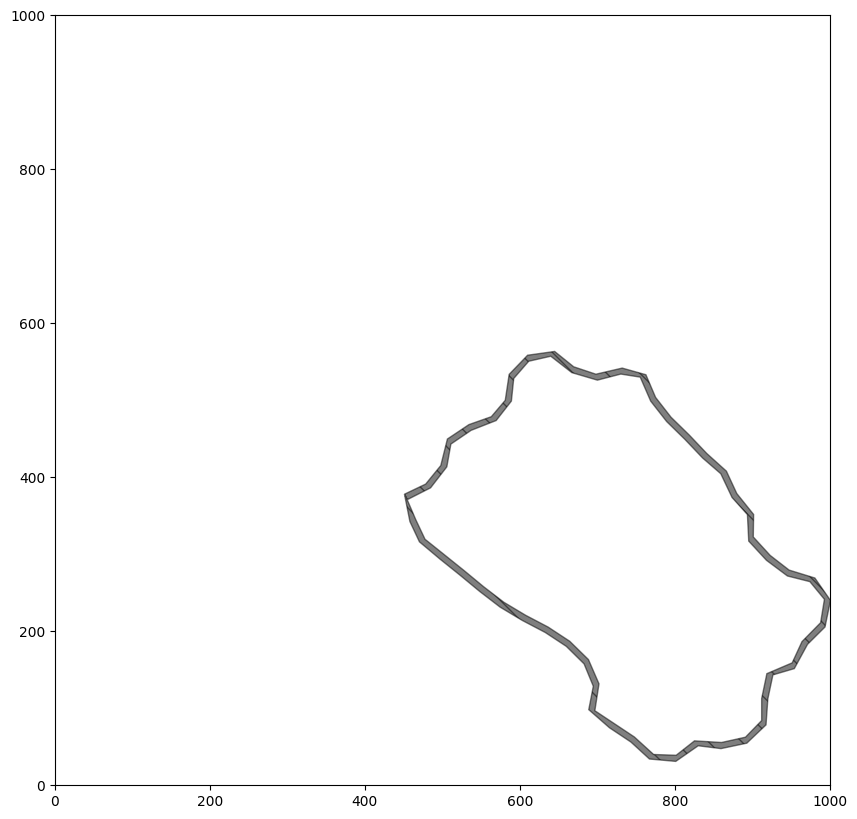

In [204]:
import json

with open('../exportData(3).txt', "r") as f:
    blobData = json.load(f)
    
#example border Array:
borderArray = np.array(blobData["cityShapes"][0]["outerPolygon"])  
print(np.min(borderArray))
borderArray = (borderArray *5)- (4.9*np.min(borderArray))

print(np.shape(borderArray))
print(np.shape(borderArray[0:2]))
borderArray = np.concatenate([borderArray[0:],borderArray[0:2].reshape(2,2)])

upArray = []
downArray = []
for i in range(len(borderArray)-1):
    inline_vector = np.array([borderArray[i+1][0]-borderArray[i][0],borderArray[i+1][1]-borderArray[i][1]])
    normal_vector = np.array([-inline_vector[1], inline_vector[0]]) / np.linalg.norm(inline_vector)
    upArray.append(borderArray[i] + road_width/2 * normal_vector)
    downArray.append(borderArray[i] - road_width/2 * normal_vector)

border_coords = np.array(upArray + downArray[::-1])
border_patch = Polygon(border_coords, color='black', alpha=0.5,hatch='\\')


plt.figure(figsize=(10,10))
ax = plt.gca()
ax.add_patch(border_patch)

ax.set_xlim(0, 1000)
ax.set_ylim(0, 1000)

plt.show()

## Types of areas:
- Residential - blue   normal dist mean 200 sqm
- Commercial - red
- Industrial - purple
- Agriculture - brown
- Public Facilities - pink  
- Renewable energy - dark green

[1203, 403]


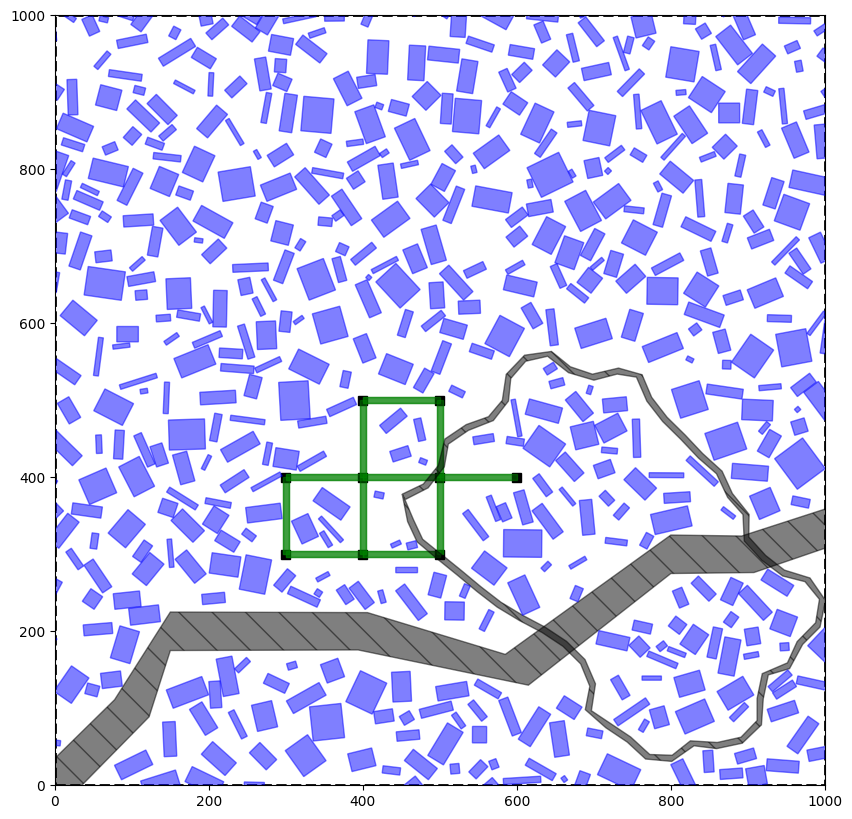

In [205]:
fig, ax = plt.subplots(figsize=(10, 10))

# create a plot
ax.set_xlim([0, side_length])   # set the x-axis limits
ax.set_ylim([0, side_length])   # set the y-axis limits
ax.set_aspect('equal')  # make the x and y axes have the same scale

add_boundary(ax, side_length)
add_roads(ax, road_data)
river = True
if river:
    assign_river(ax, river_data, 50, 0)

# ax.add_patch(place_building(ax,'residential', 100, 900, ["rectangle",100,50],1.1))
# place_building(ax,'commercial', 100, 800, ["circle",50,50],0.5)
temp = Polygon(border_coords, color='black', alpha=0.5,hatch='\\')
ax.add_patch(temp)

required = [['residential',["rectangle",10,50]],['commercial',["circle",10,50]]]
for loop in range(1000):
    required.append(['residential',["rectangle",np.random.uniform(5,50),np.random.uniform(5,50)]])
add_req_buildings(ax,required,side_length)



plt.show()

In [41]:
import json

# output the map
fig.savefig('city_map.png', dpi=300)

# output the data
# Extract Voronoi vertices (junctions)
junctions = vor.vertices.tolist()

# Create adjacency matrix
num_junctions = len(junctions)
adjacency_matrix = np.zeros((num_junctions, num_junctions))

# Fill the adjacency matrix
for ridge in vor.ridge_vertices:
    if -1 not in ridge:  # Ignore ridges at infinity
        i, j = ridge
        adjacency_matrix[i, j] = adjacency_matrix[j, i] = 1

# Convert adjacency matrix to list for JSON serialization
adjacency_matrix = adjacency_matrix.tolist()

# Store building information
buildings = []
for patch in ax.patches:
    if isinstance(patch, Rectangle):
        building_info = {
            'type': 'rectangle',
            'x': patch.get_x(),
            'y': patch.get_y(),
            'width': patch.get_width(),
            'height': patch.get_height(),
            'color': list(patch.get_facecolor()),
            'centroid': [patch.get_x() + patch.get_width() / 2, patch.get_y() + patch.get_height() / 2],
            'building_height': np.random.uniform(10, 100)  # Assign a random height to each building
        }
    elif isinstance(patch, Circle):
        building_info = {
            'type': 'circle',
            'x': patch.center[0],
            'y': patch.center[1],
            'radius': patch.radius,
            'color': list(patch.get_facecolor()),
            'centroid': [patch.center[0], patch.center[1]],
            'building_height': np.random.uniform(10, 100)  # Assign a random height to each building
        }
    buildings.append(building_info)

# Create a dictionary to store the data
data = {
    'junctions': junctions,
    'adjacency_matrix': adjacency_matrix,
    'buildings': buildings
}

# Output the data to a JSON file
with open('city_data.json', 'w') as f:
    json.dump(data, f)